In [131]:
import os
import shutil
import sys

import json

import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd
import implicit

from tqdm.notebook import tqdm

In [187]:
# Just choose the name of the dataset directory
dataset  = 'ml-20m'
DATA_DIR = '/Users/tomas/Documents/FEUP/Tese/data/' + dataset
PARSE_DATA_DIR = os.path.join(DATA_DIR, 'processed_70_10_20')

In [195]:
# K = 10
pre_meta_data_df = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'total_results_k_10.csv'), header=0)

In [210]:
# K = 20
pre_meta_data_df = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'total_results_k_20.csv'), header=0)

In [227]:
# K = 100
pre_meta_data_df = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'total_results_k_100.csv'), header=0)

In [228]:
pre_meta_data_df = pre_meta_data_df.drop('uid', 1)

In [218]:
pre_meta_data_df = pre_meta_data_df.drop('knn_tfidf_ndcg', 1)
pre_meta_data_df = pre_meta_data_df.drop('knn_cos_ndcg', 1)
pre_meta_data_df = pre_meta_data_df.drop('knn_bm25_ndcg', 1)

In [229]:
pre_meta_data_df['zeroes'] = 0.000001

In [230]:
pre_meta_data_df.head()

,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg,knn_cos_ndcg,knn_tfidf_ndcg,knn_bm25_ndcg,zeroes
0,0.000000,0.277082,0.430677,0.000000,0.000000,0.000000,0.180031,0.000001
1,0.642568,0.190551,0.191369,0.388123,0.717969,0.812639,0.234378,0.000001
2,0.175579,0.259863,0.258610,0.242597,0.163513,0.183989,0.183459,0.000001
3,0.191959,0.157767,0.164272,0.165443,0.177184,0.162608,0.150844,0.000001
4,0.338630,0.183169,0.323173,0.397366,0.374515,0.326060,0.172472,0.000001


In [231]:
pre_meta_data_dict = dict([(r[0], list(pre_meta_data_df.columns[np.argsort(list(r)[1::])])) \
    for r in list(pre_meta_data_df.to_records())])

In [232]:
#pre_meta_data = pd.DataFrame.from_dict(pre_meta_data_dict,orient = 'index',columns=['fifth_place', 'fourth_place', 'third_place','second_place','first_place'])
pre_meta_data = pd.DataFrame.from_dict(pre_meta_data_dict,orient = 'index',columns=['eight_place', 'seventh_place', 'sixth_place', 'fifth_place', 'fourth_place', 'third_place','second_place','first_place'])
#pre_meta_data = pd.DataFrame.from_dict(pre_meta_data_dict,orient = 'index',columns=['seventh_place', 'sixth_place', 'fifth_place', 'fourth_place', 'third_place','second_place','first_place'])

In [233]:
pre_meta_data.head(10)

,eight_place,seventh_place,sixth_place,fifth_place,fourth_place,third_place,second_place,first_place
0,als_ndcg,most_popular_ndcg,knn_cos_ndcg,knn_tfidf_ndcg,zeroes,knn_bm25_ndcg,bpr_ndcg,lmf_ndcg
1,zeroes,bpr_ndcg,lmf_ndcg,knn_bm25_ndcg,most_popular_ndcg,als_ndcg,knn_cos_ndcg,knn_tfidf_ndcg
2,zeroes,knn_cos_ndcg,als_ndcg,knn_bm25_ndcg,knn_tfidf_ndcg,most_popular_ndcg,lmf_ndcg,bpr_ndcg
3,zeroes,knn_bm25_ndcg,bpr_ndcg,knn_tfidf_ndcg,lmf_ndcg,most_popular_ndcg,knn_cos_ndcg,als_ndcg
4,zeroes,knn_bm25_ndcg,bpr_ndcg,lmf_ndcg,knn_tfidf_ndcg,als_ndcg,knn_cos_ndcg,most_popular_ndcg
5,most_popular_ndcg,zeroes,knn_cos_ndcg,knn_tfidf_ndcg,als_ndcg,knn_bm25_ndcg,bpr_ndcg,lmf_ndcg
6,bpr_ndcg,knn_bm25_ndcg,zeroes,lmf_ndcg,most_popular_ndcg,knn_tfidf_ndcg,knn_cos_ndcg,als_ndcg
7,zeroes,most_popular_ndcg,bpr_ndcg,lmf_ndcg,knn_cos_ndcg,knn_tfidf_ndcg,als_ndcg,knn_bm25_ndcg
8,lmf_ndcg,zeroes,knn_bm25_ndcg,most_popular_ndcg,knn_cos_ndcg,knn_tfidf_ndcg,als_ndcg,bpr_ndcg
9,als_ndcg,bpr_ndcg,lmf_ndcg,knn_bm25_ndcg,zeroes,most_popular_ndcg,knn_cos_ndcg,knn_tfidf_ndcg


### Helper

In [144]:
def plot_stats(labels, values, title):
    """Plot histogram and pie chart  
        Args:
            labels: labels to be used in the plots 
            values: values to be ploted
            title: title of the plots

        Returns:
        two plots
    """
    # Create arrays for the plot
    x_pos = np.arange(len(labels))
    
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, values, align='center', alpha=0.8)
    ax.set_ylabel('count')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.show()
    
    fig_pie, ax_pie = plt.subplots()
    #ax_pie.pie(values, labels=labels, colors= ['b','g','r','c','y'], autopct='%1.1f%%')
    ax_pie.pie(values, labels=labels, autopct='%1.1f%%')
    ax_pie.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax_pie.set_title(title)


    plt.show()
    
    
    
    return

## Plots

#### Top Each place

--- plots of eight_place  ---


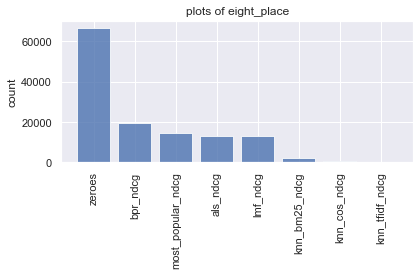

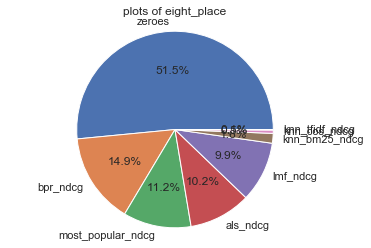

--- plots of seventh_place  ---


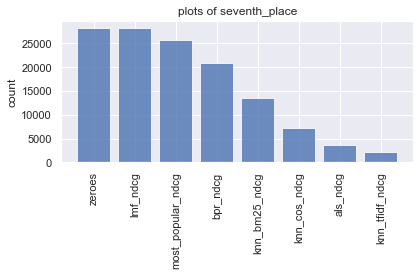

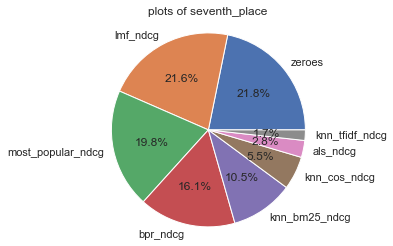

--- plots of sixth_place  ---


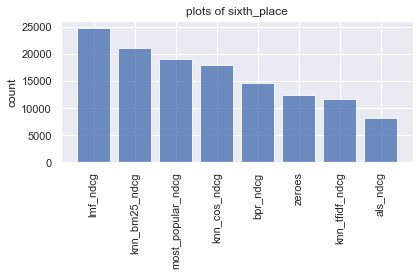

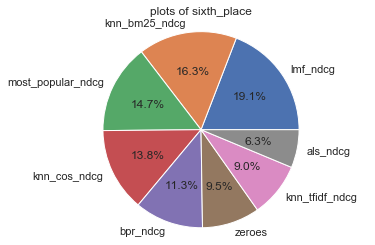

--- plots of fifth_place  ---


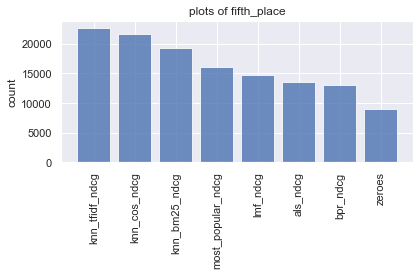

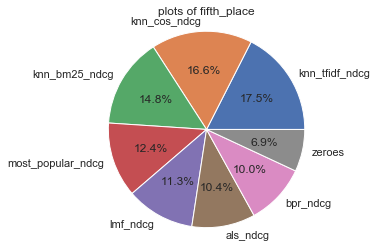

--- plots of fourth_place  ---


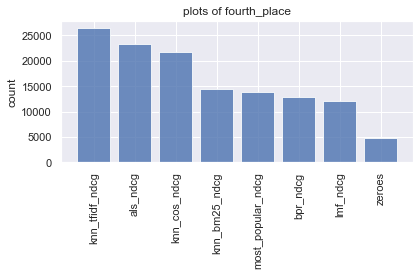

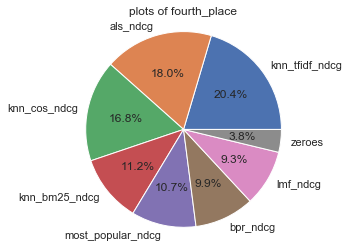

--- plots of third_place  ---


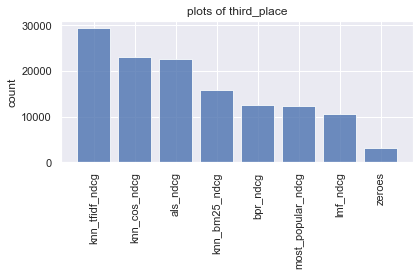

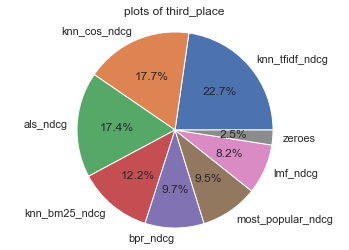

--- plots of second_place  ---


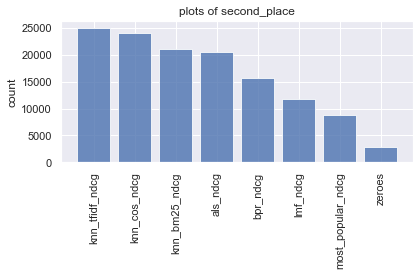

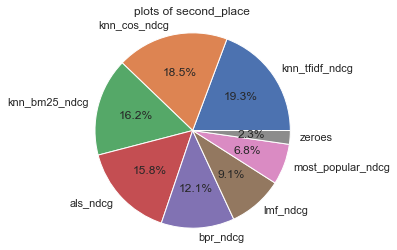

--- plots of first_place  ---


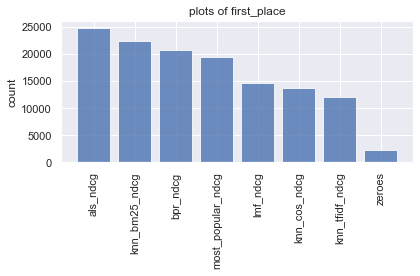

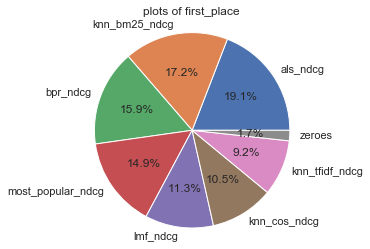

In [234]:
for col in pre_meta_data.columns:
    print('--- plots of', col , ' ---')
    x_place = pre_meta_data[col].value_counts().to_dict()
    plot_stats(x_place.keys(), x_place.values(), 'plots of '+ col)

### Top 2

In [13]:
duplas = pre_meta_data.groupby(["first_place", "second_place"]).size().sort_values(ascending=False).reset_index(name='count').head(10)

In [14]:
duplas_dict = dict( ("(1:" + duplas.loc[i, "first_place"] + ",2:" + duplas.loc[i,"second_place"] + ")", duplas.loc[i, "count"]) for i in range(len(duplas)))

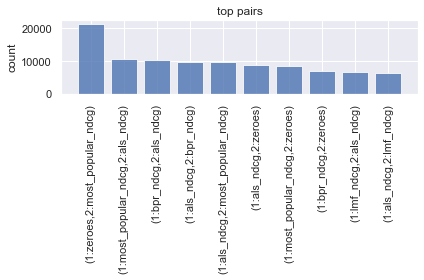

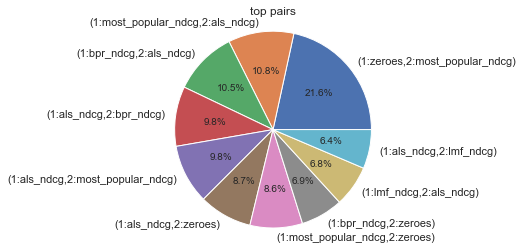

In [15]:
plot_stats(duplas_dict.keys(), duplas_dict.values(), "top pairs")

### Top 3

In [16]:
triplos = pre_meta_data.groupby(["first_place", "second_place", "third_place"]).size().sort_values(ascending=False).reset_index(name='count').head(10)

In [17]:
triplets_dict = dict( ("(1:" + triplos.loc[i, "first_place"] + ",2:" + triplos.loc[i,"second_place"] + ",3:" + triplos.loc[i,"third_place"] + ")", triplos.loc[i, "count"]) for i in range(len(duplas)))

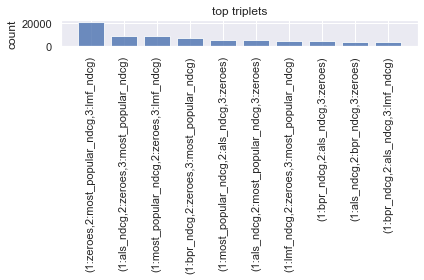

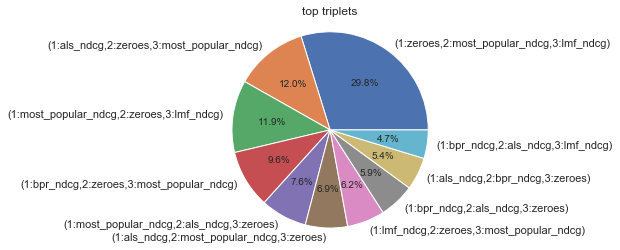

In [18]:
plot_stats(triplets_dict.keys(), triplets_dict.values(), "top triplets")